In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
from nltk.tokenize.casual import TweetTokenizer
import string
import re
from random import shuffle
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split

import string

%matplotlib inline

In [2]:
raw_hate = pd.read_csv('./hate-speech-and-offensive-language/data/labeled_data.csv')

In [3]:
raw_hate.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


"Unnamed" is just a redundant index, "count" is the number of users who labeled a tweet, "hate_speech" "offensive_language" and "neither", are the number of votes a tweet got for each of those classes. "Class" is the final label assignment determined by majority vote. "tweet" is the text of each tweet. Because I only care about the text and the class I'm dropping the rest.

In [4]:
raw_hate = raw_hate[['class', 'tweet']]

In [5]:
raw_hate.dtypes

class     int64
tweet    object
dtype: object

In [6]:
raw_hate.isnull().sum()

class    0
tweet    0
dtype: int64

In [7]:
raw_hate.shape

(24783, 2)

In "class" the values represent:
0 - hate speech
1 - offensive  language
2 - neither

In [8]:
raw_hate.nunique()

class        3
tweet    24783
dtype: int64

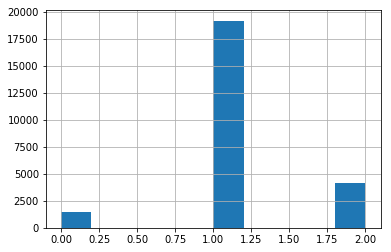

In [9]:
raw_hate['class'].hist();

In [10]:
raw_hate['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [11]:
tweets = raw_hate['tweet']

In [12]:
tweets.shape

(24783,)

In [13]:
type(tweets)

pandas.core.series.Series

In [14]:
tweets[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [15]:
tweets[:3]

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
Name: tweet, dtype: object

In [16]:
tweets = tweets.as_matrix(columns=None)

In [17]:
#tweets = np.array2string(tweets)

In [18]:
print(tweets[:3])

["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."
 '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!'
 '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit']


In [19]:
type(tweets)

numpy.ndarray

In [20]:
print(tweets[20])

" broke bitch cant tell me nothing "


In [21]:
def no_punc(tweets_arr):
    translator = str.maketrans('', '', string.punctuation)
    
    tweets_no_punc = [t.translate(translator) for t in tweets_arr]
    
    return tweets_no_punc


In [22]:
tweets = no_punc(tweets)

In [23]:
print(tweets[:5])

[' RT mayasolovely As a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out', ' RT mleew17 boy dats coldtyga dwn bad for cuffin dat hoe in the 1st place', ' RT UrKindOfBrand Dawg RT 80sbaby4life You ever fuck a bitch and she start to cry You be confused as shit', ' RT CGAnderson vivabased she look like a tranny', ' RT ShenikaRoberts The shit you hear about me might be true or it might be faker than the bitch who told it to ya 57361']


In [24]:
tweets = [t.lower() for t in tweets]

In [25]:
print(tweets[:5])

[' rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out', ' rt mleew17 boy dats coldtyga dwn bad for cuffin dat hoe in the 1st place', ' rt urkindofbrand dawg rt 80sbaby4life you ever fuck a bitch and she start to cry you be confused as shit', ' rt cganderson vivabased she look like a tranny', ' rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya 57361']


In [30]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [29]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_stops = ["ff", "rt", 'amp']
stopwords.extend(other_stops)

def remove_stop_words_from_tweet(a_tweet_word_array):
    stopwords_free_tweet = [word for word in a_tweet_word_array if word not in stopwords]
    return stopwords_free_tweet

def remove_stop_words(tweets_list):
    words_in_tweets = [t.split() for t in tweets_list]
    stopwords_removed = [remove_stop_words_from_tweet(tweet) for tweet in words_in_tweets]
    stopword_free_tweets = [' '.join(split_tweet) for split_tweet in stopwords_removed]
    return stopword_free_tweets
        

In [31]:
tweets = remove_stop_words(tweets)



In [32]:
tweets[:3]

['mayasolovely woman shouldnt complain cleaning house man always take trash',
 'mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place',
 'urkindofbrand dawg 80sbaby4life ever fuck bitch start cry confused shit']

In [33]:
tweet_df = pd.DataFrame(tweets)

In [34]:
tweet_df.head()

,0
0,mayasolovely woman shouldnt complain cleaning ...
1,mleew17 boy dats coldtyga dwn bad cuffin dat h...
2,urkindofbrand dawg 80sbaby4life ever fuck bitc...
3,cganderson vivabased look like tranny
4,shenikaroberts shit hear might true might fake...


In [35]:
tweet_df.columns = ['tweets']

In [36]:
tweet_df.head()

,tweets
0,mayasolovely woman shouldnt complain cleaning ...
1,mleew17 boy dats coldtyga dwn bad cuffin dat h...
2,urkindofbrand dawg 80sbaby4life ever fuck bitc...
3,cganderson vivabased look like tranny
4,shenikaroberts shit hear might true might fake...


In [37]:
tweet_df['tweets'] = tweet_df['tweets'].str.replace('\d+', '')

In [38]:
tweet_df.head()

,tweets
0,mayasolovely woman shouldnt complain cleaning ...
1,mleew boy dats coldtyga dwn bad cuffin dat hoe...
2,urkindofbrand dawg sbabylife ever fuck bitch s...
3,cganderson vivabased look like tranny
4,shenikaroberts shit hear might true might fake...


In [39]:
tweet_df.to_csv('./hate-speech-and-offensive-language/data/df_for_gensim.csv', index=False)

# load this in another notebook where you'll finish preprocessing and build the NN.

**The below cells are other approaches to the rest of preprocessing that you decided against after doing it.**

In [40]:
tweet_df.tweets.nunique()

24685

In [41]:
one_long_string = ', '.join(tweets)

In [42]:
type(one_long_string)

str

In [43]:
print(one_long_string[:200])

mayasolovely woman shouldnt complain cleaning house man always take trash, mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place, urkindofbrand dawg 80sbaby4life ever fuck bitch start cry confuse


In [44]:
one_long_string = one_long_string.replace(',', '')

In [45]:
print(one_long_string[:300])

mayasolovely woman shouldnt complain cleaning house man always take trash mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place urkindofbrand dawg 80sbaby4life ever fuck bitch start cry confused shit cganderson vivabased look like tranny shenikaroberts shit hear might true might faker bitch tol


In [48]:
wordlist = one_long_string.split()

## this takes forever because you used a loop with append in it dummy. vectorize it at some point.

wordfreq = []
for w in wordlist:
    wordfreq.append(wordlist.count(w))

In [49]:
print(wordfreq[:10])

[1, 100, 30, 27, 6, 129, 513, 284, 295, 1124]


In [50]:
type(wordfreq)

list

In [51]:
from collections import OrderedDict

In [52]:
word_count_dict = OrderedDict(zip(wordfreq, wordlist))

In [53]:
print(word_count_dict)

OrderedDict([(1, 'httptcoh0dyebvnzb'), (100, 'theyre'), (30, 'small'), (27, 'wild'), (6, 'lolol'), (129, 'dude'), (513, 'man'), (284, 'always'), (295, 'new'), (1124, 'trash'), (187, 'boy'), (24, 'group'), (2, 'combination'), (568, 'bad'), (10, 'cuff'), (289, 'dat'), (1866, 'hoe'), (37, 'swag'), (67, 'reason'), (3, 'diabetes'), (41, 'save'), (28, '9'), (258, 'ever'), (1406, 'fuck'), (8120, 'bitch'), (143, 'start'), (57, 'cheat'), (29, 'million'), (1249, 'shit'), (5, 'chu'), (470, 'look'), (2759, 'like'), (48, '128553'), (66, 'favorite'), (121, 'might'), (149, 'women'), (471, 'ya'), (7, 'drove'), (21, 'worm'), (477, 'still'), (626, 'fucking'), (2334, 'hoes'), (184, 'smh'), (69, 'r'), (469, 'hate'), (175, 'another'), (1289, 'got'), (220, 'much'), (276, 'niggah'), (298, 'cause'), (2063, 'im'), (65, 'lookin'), (244, 'put'), (3045, 'bitches'), (179, 'us'), (46, 'lying'), (1428, 'get'), (448, 'back'), (610, 'thats'), (92, '5'), (1033, 'lol'), (22, 'lol8221'), (11, 'sugar'), (13, 'goal'), (70,

In [54]:
w_count_df = pd.DataFrame(list(word_count_dict.items()), columns=['count', 'word'])

In [55]:
w_count_df.head()

,count,word
0,1,httptcoh0dyebvnzb
1,100,theyre
2,30,small
3,27,wild
4,6,lolol


**The rest of this is just crap you copied from a github notebook that was recommended in the paper. I deny thee Satan.**

In [56]:
stemmer = PorterStemmer()

def my_tokenize(tweet_lst):
    tokens = [stemmer.stem(t) for t in tweet_lst]
    clean_tweets = [w for w in tokens if w not in stopwords]
    return clean_tweets

In [58]:
tweet_tokens = my_tokenize(tweets)

In [59]:
print(tweets[:10])

['mayasolovely woman shouldnt complain cleaning house man always take trash', 'mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place', 'urkindofbrand dawg 80sbaby4life ever fuck bitch start cry confused shit', 'cganderson vivabased look like tranny', 'shenikaroberts shit hear might true might faker bitch told ya 57361', 'tmadisonx shit blows meclaim faithful somebody still fucking hoes 128514128514128514', 'brighterdays sit hate another bitch got much shit going', '8220selfiequeenbri cause im tired big bitches coming us skinny girls8221', 'might get ya bitch back thats', 'rhythmixx hobbies include fighting mariam bitch']


In [60]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

In [61]:
for t in tweets:
    t = preprocess(t)
    print(t)

mayasolovely woman shouldnt complain cleaning house man always take trash
mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place
urkindofbrand dawg 80sbaby4life ever fuck bitch start cry confused shit
cganderson vivabased look like tranny
shenikaroberts shit hear might true might faker bitch told ya 57361
tmadisonx shit blows meclaim faithful somebody still fucking hoes 128514128514128514
brighterdays sit hate another bitch got much shit going
8220selfiequeenbri cause im tired big bitches coming us skinny girls8221
might get ya bitch back thats
rhythmixx hobbies include fighting mariam bitch
keeks bitch curves everyone lol walked conversation like smh
murda gang bitch gang land
hoes smoke losers yea go ig
bad bitches thing like
bitch get
bitch nigga miss
bitch plz whatever
bitch love
bitches get cut everyday b
black bottle bad bitch
broke bitch cant tell nothing
cancel bitch like nino
cant see hoes wont change
fuck bitch dont even suck dick 128514128514128514 kermit videos bout fuc

8220untouchablet never seen many perfect bitches til made twitter 128564 1280569749650398221128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175128175
8220vinnyguadagnino im boss ass bitch bitchbitchbitchbitchbitchbitch8221 sarahninjaginga
8220vabtwin8211 vivalaquintaa agreed eating pussy much better8221they nasty
8220vishaldagod fuck wcw dats bitch crush8221
8220weeedith want bitches big boooty bitches8221
8220worstraplyrlcs httptcohe19tifqfx8221 trash
8220wavygodd dont like ghetto female8221128567128078
8220weakassdrex jennifer hudson lose weight anybody fat ass hoes8221128514128514128514128514
8220weirdlilthingz stop giving nigga pussy stop actin like care8221 true totally
8220whaletail wanna go workout 

httrdcrising fuck redskins bitch
htownracer shit tell pussy come retirement show kareem jackson get respect
halawa0402 sick muzzie trash jewjitsugrl joedouglas1 darknight420 blackorchidm16 httptcokqrmhszmpj
haleyjoanis lick pussy crack
halfbakdkitten ill finger ur tight pussy slowly youll moaning name bby
haliemaranda huntermoore bitch u perfect
halleybrenks3 interesting hick
hansolosson bruh really rocking toaster face lmaoooo prolly got 0 bitches man
harbison92 knw pussy hate u ask tht
harleyyyquinn trash
harrydillema svenstweet wltrrr vraag svenhij denkt hoe lichter van kleur hoe beter het morele kompas werkt ik ben kleurenblind
harrysboylouis curveme laughing joke 911 big different bitch
harveylevintmz sly309 want got want got americathey got word nigger want
harveylevintmz sal tryin 2 pull k ferderlinelazy ass son bitch
haseenabakhtali steen020 madraq altyd zo geweest hoe vaak men ook zegtdit nooit meerlozewoordenpuntjebijpaaltje vertonen z dierngedrag
hazeleyedbarbi walks away pu

therealjohndoe dude fucking mono sucks bed trash
therealjohndoe thats nate dumbass mock
therealkevinmcb sauerkraut saul punk ass bitch
therealoweifie us payback bitch hahaha lt3 happy valentines day though
therealoweifie good one fucking bitch ass
therealsaigon gonna ima chase club like mobb deep pussy
therealsaigon explains cause bitch whine
therealtahiry lmao dumb hoe budden made popular please stop irrelevant one cares slut
therealaaw 128514128514128514128514 pot gold ass nigguh
thereval catyou pussy black bored kid kills cop starting firewhere outrage phony fnthefive
theryanadams word bird
theseanyv think reconsider hes little bitch one true god almighty cthulhuplease soul seany
theseanyv quit pussy call first last name plus ssn ya poon
theseanyv subtweeting using hashtag oomf whats difference p jk jerkin yo dick ya nigger faggot
theseanyv would help others cant handle uppers cripples plus moderation isnt taken consideration itll bad
theshoebible steamedgreens hoes clean
thesicthem

kiefferjason pussy
kiefferjason pussy nigga term
kiefferjason restricton g means license revoked stop making excuses straight bitch
kiefferjason sorry dont know tell get pussy ass twitter
kiefferjason u bring bitch
kiefferjason u tool bet u want shoot tho pussy ass nigga u cant dem hands tho
kiefferjason u feel like dumb ass dont u pussy boy
kiefferjason u going get dropped bitch im fucking nigga got fucking dick
kiefferjason u made drive way plano wanna bitch
kiefferjason u want panda express someone break like fuck stick plan go plano get bitch blood
kiefferjason u see saturday u dont show bitch made nigga pussy ass nigga
kiefferjason umm sure hoes talk arent ugly
kiefferjason wtf r u talking plano tx r u talking pussy boy
kiefferjason wtf u think u ole pussy ass nigga
kiefferjason yes bitch fucking square
kiefferjason dumb fuck thats fucking full address dumbass dont live plano fuck would know retard
kiefferjason fucking retared even funny bitch im going sleep u
kielag3 128514128514

brad pitt older charlie sheen fuckkkkkkkkkkkkk
brady heard yall say washed washing league hoe ass niggas
brag bout hoes prolly get 0 pussy
brag hoes hittin ask pic show sorry ass female laugh
brandon jennings trash
break shit fuck lawgrrrrfuck shitpunch bitch
breakfast fried chicken jerk chicken tater tots white rice nd press yellow rice nd beans mac nd cheese httptcousz8gjnzl0
breakfast champions shrimp lobster balls sandusky french fries nd nice big quahog clam for8230 httptcouajukcoafv
breaking news ur little bitch
breaking yo bitch like kitkat nigga
breakup anthem 128680128680128680we threw shidd lemme fall back pick side hoes cuz stayed contact 128526 httpstcobnqd4fifrq
breezy gotta sleep hoe
briahna told best advice ever gave aint nothing cut dat bitch lmao
brie said together since born guys twins duh bitch omg wrote script bellatwins
brilliant job nelsoncanache limp back pits without causing yellow wish didnt need though plm
bring niggah icecream
bring another bitch real nigga
b

hold women leaving good men quotes seen nigga girl post instagram copied googleu hoes crazy 999665039999665039
holder8217s justice department isn8217t interested facts ferguson httptco7vh4typmht race hustling bitches disgraceful
holy fuck bomb ass bitches bucees
holy fuck white bitch 4 baby daddy straight goes uses condoms anyways bitch maybe youd stay outta clinic
holy monkey balls warm today
holy sheep shit havent instagram coons age im seeing pictures like 20 weeks ago haha
holy shit retard episode wheel fortune fantastic
home chicken penne alfredo oreos banjo
homemade soup good vegetables side crackers httptcolirwgwkdze
homework boonies date caitlin tonightgtgt
honestly think would trash young man ill fuck bitch ill smack mother prolly shot ugly ass dog
honestly point doubt id fuck miley cyrus anymore bitch mess
honestly hoodiest ratchet bitch asked prom im dere
honestly enough bad bitches universe everyone including dykes
honkey ass bitch tryna tell shit
hood niggas bitches love e

gz trayvon would alive right second smoking bowl tweeting bitches hoes nice kid
coward afraid showing faithjust another devils bitch
dated girl lived mack road could get holy trinity sacramento ghettos daily basis
everyone knew real youfakest bitch know
new local mall wasnt ghetto
bitches really knew
pussy lips could talk ill go like whispering
hoe im hoe
hoe social media hoe real life
aint yo lady u better text ass good morning quit treating side hoes like wifey material
aint talkin talking cus know bitches cant stop talking trustissues
dont appreciate say yes bitch aint real
hates kissed mouth hoetell different
know yo name way meet dat bitch eatta
makes good sandwhich give good blowy wife dat hoe way eat eatting
wears dinner shes paying food im treating bitch like stranger httptcopm5aa6plw0
shell tell shes badd bitch listen shes bad health
one isnt anglosaxon protestant right alive us none foreign filth
someone part james x hes white trash cultist
someone pushes hard today may surpr

never tell bitch u
never serious cthaqueen thought finna cruise new bitch 1285531282731282989995 httptcomvcnpytxo8
never trust bitch cause bitches fuckin anyone say know faithful bitch gotta get one
never trust bitch took nigga 128175
never trust nicca volunteers another man info
never turned back birds
never item psycho bitch
neverrr play stupid im far bitches might stupid 128581
new timbersfc jersey yellow green chevron stripe like charlie browns jersey
new avi bitches weak
new bitch already second episode
new boss said buttons shirt cant white colored hoes sharpie 128514 glossy
new pussy aint always better
new show announced lutsen mn papa charlies december 11 2010 httpartistdatacoma2oy4
new show announced lutsen mn papa charlies january 29 2011 httpartistdatacoma33ck
new song coming ray rice hoe httptcobul6issmfh
new strategy get bitches bruno mars
new test makes poop neon colored colon cancer 8594 httptcogigzo0ntpd
new years ever get bitch loaded gfu 2013 127881 httptco3kkvidm5
ne

damonddawg peek boo bitch swag scare ya kids nowthatsfresh whats tygas worst bar tygabars
danbilzerian apple new iphone software shit maybe ill sue u cunts request damages based pussy ive missed b8230
danbilzerian boy obviously gonna slaying pussy tonight dressed ninja turtle httptcosu2hnfq6s8
dandanmanlyman 00sexilexi00 swiggety swag love fag
danharrison1985 128514 cecilhurt charlie strong got 53man roster nearly quickly texans
danosuhashtag ever look bitch like bitch
danaperino handed flight must good hands bird httptco7vjwdcdtxv
danielbiltmore basic bitches gt basic cable
danielgennaoui bird courts females building beautiful nest bright objects httptcogi2rrlgro6 8230 wildlife http8230
danielmtz1997 20 rts ill go say fuck er right pussy 128514128514128514128514128514 httptcorzfhabwtsv
dankychan88 dumb bitches broke tv went wal mart fucked wokeup smart tv lol
dannydevito wisconsin iasip nice work bitches
dannytanner highest score flappy bird cant beat httptcoi2qgswipdc
daraunn joshuat

nickswagypyoung happy halloween rick james aka swaggy charlie murphy bigmeat2000 haha darkness everybody httptcoy8230
nickswardson yoda pussy thats look like morning
nickstape15 dej loaf trash pure trash
nicoromero23 edm music trash af annoying
nicoleorozco23 kansas bitch longhairdontcare countrygirl ohio yourewelcome lovethisgirl cle loveit httptcollw3imtcug
nigeld look chicks joebudden follow tell aint got hoes httptcoiw9wpg1sfy
nigeld joebudden wanna state record don8217t hoes httptcopcd2slvkxy
niggahyfenasian tat fucking name let em know love boy wassup wonder many bitches made mistake year
niggasblike nigga aux cord playin trash shit httptcoo5ezd8fsq9
nightvaleradio quick lesson birds bees birds looming oily sudden bees bulbous shrieking hungry8230
niiquebaby freefaceridess cancer still killing half hoes httptcoiyuiuhqr0l jus cuz cancer dont mea8230
nikkiinick22 customers like make prices like bitch dont
nikowavy lot bitches like gamble money put emotions feelings heart line
nikow

beautifulkeezy 8220100046729 8220beautifulkeezy tf lyssa toilet mouth ass 1280641285308221 wassup8221you twatching hoe 128514128514
beautifulkeezy 8220100046729 beautifulkeezy lmfao bitch talking 1285141285148221but im talking bubba voice 128514128514128514128128
beautifulkeezy 8220100046729 small ass pants 1285148221bitch 128514128514128514
beautifulkeezy 8220100046729 side hoe 1285141285141285141281281281281280748221omg 128514128514128514128514128184
beautifulkeezy 8220sofpizzie hoes gonna stunting florida pussy1285861285481285488221128514128514128514128514128514128128128080
beautifulkeezy hoe bang big got nerves think better us bitches chill 128564
beautifulkeezy ion understanding hoes drop yall nuts bitch ass cant hear mouse piss 8230
becool4 8220lilswahh face make tell bitch httptcojvm1k8togx8221ltlt make dat face much
blessedale stupid lil ass bitch aint fuckin chuuu
bmoremartyr wbpooh3x fuck wrong thinking wife hoe128514128080128552128516
breddifferent niggas fuck yah good eat y

quecaine white bitches love cocaine
queenallyssa man call bitch yall arguing dont think really bitch actin like one
queenalyzee aint friends hoe
queencnt 8220100d 90 niggas goofy act like bitches8221 aint lyin
queenthottiex3 proud mahanain 9825 still hoe tho
quirkisms jeter arod class trash
rachaelgoss wants chill campus w throw bibles bitches taking walk shame1006710068
radiomaru nerds cool get really judgey nerds passionate things arent passionate abo
radiotouren duchess cambridge present first yellow jersey httptco8vvnu9drfm tdf
raejeanhightowe 8220swuuthegod stop 9995 playin bitch 128589 know im mvp 1279421285268221
raeleenehoe hate bitch know dont fuck really trying talk like cool nahh bitch foh dont 8230
raiderlevel like dont go raider games ghetto people get jumped lmao like well shit sound lik8230
randomshxt need dick suckedfuck 1 bitch need 999665039 sluts
randycaliboi hear ugly bitch talk another ugly bitch 128528 httptcorwvyvpye2n
randypop84 u bitches aint paying billsso fuc

bitches telling let go ones would go grab right you128175128079
bitches failed geometry know exactly angle use take perfect selfie
bitches chicks posing wit pics instagram likes bitches texting boyfriends aint textin back
shit bitches brag hilarious
solution simple buy bitch
spot open take better grab another bitch determined beautiful enough
streets dirty hoe niggad try wife though
thing working black people bitches never fucking time wanna complain short check bitch dietoday
thinner eyebrow crazier bitch
tweeter gurl tumblr using taser roaches im assuming house bitches shame
two ringless fags everybodyhatesx barkley reggie talking nonsense entire game
type bitches like think broke disgusting
ugliest bitches swear bad 128564
undesirables kinghorsedick vianawf 128557128557128557128557128557 bitches big bruh
value abu qutada8217s statement credentials jihadi circles impeccable he8217s facing trial terrorism charges
way hawk girl green lantern trust hoes nope
way fuck would think love bi

yasss brownies ice cream 128523 httptco8qla3jsglg
yay im redneck piece shit sorrynotsorry
yayyyy im gonna jacking bitches day today httptcolemilfu1
yaz bitch yaz httptcoeomrmqwnqt
yea see ya hoe
yea im illiterate hot skillet bitch 128079
yea oscar grouch bitch live fuckin trash
yea alright redneck white trashcamopearls stupid niggers hollering car going road trying hit fuck yall
yea bitch 128514 dat shit feel httptcoc7h0tfjdet
yea buddy yalljustdontkno lot nba trash talk going
yea randy white 745 changed whole mind hoe nice
yea bad hoe
yea bad hoe
yea mike bitchass referee tokyo royceda59
yea bitch crazy
yeaaa bitch dog like shaggy yea stay clean get dirty like harry
yeah chris brown definitely realest waffle cone colored nigga time bullshit song b thats exactly feelin
yeah tell weather wont gettin pussy today
yeah acne still pull hotter bitches
yeah tried bein blind shit lol peace bitch127797
yeah atampt needs get fucked fuckin water proof galaxy got cheerios slidin bitch shit
yeah bi

In [62]:
from nltk.tokenize import word_tokenize

stopwords=stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

word_tokens = word_tokenize(tweets)
 
filtered_sentence = [w for w in word_tokens if not w in stopwords]
 
filtered_sentence = []
 
for w in word_tokens:
    if w not in stopwords:
        filtered_sentence.append(w)

print(word_tokens)
print(filtered_sentence)

TypeError: expected string or bytes-like object

In [63]:
preproc_tweets = preprocess(tweets)

TypeError: expected string or bytes-like object

In [64]:
tokenize(preproc_tweets)

NameError: name 'preproc_tweets' is not defined

In [65]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [70]:
tweet_tknizer = vectorizer.fit(tweets)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [71]:
toked_tweets = tweet_tknizer.transform(tweets)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [72]:
print(toked_tweets)

  (0, 7391)	6.4929403999463435
  (0, 6804)	4.1022007927433854
  (0, 6480)	8.345324490990834
  (0, 6467)	5.185668025782604
  (0, 5984)	7.716715831568459
  (0, 4379)	4.820803893296679
  (0, 3351)	6.265882949310998
  (0, 1488)	7.3112507234602955
  (0, 1403)	7.166669494649188
  (0, 158)	5.483123610061365
  (1, 6249)	6.898405508054508
  (1, 5216)	6.800425099694305
  (1, 3161)	2.8266173613252086
  (1, 1700)	8.22754145533445
  (1, 1698)	10.889179892118245
  (1, 1621)	8.815328120236568
  (1, 1024)	5.553392805907921
  (1, 373)	4.813464410808633
  (2, 6269)	5.6798339043074195
  (2, 5945)	4.008851077543443
  (2, 5813)	7.785708703055411
  (2, 5812)	7.750617383244141
  (2, 4046)	5.324899604846471
  (2, 2501)	5.608524876602638
  (2, 2495)	3.486966632340156
  :	:
  (24780, 7600)	6.483184225000979
  (24780, 7175)	8.920688635894397
  (24780, 7172)	5.324899604846471
  (24780, 4886)	6.532945734560043
  (24780, 4060)	8.478855883615356
  (24780, 4059)	3.248893836731592
  (24780, 2578)	5.612581677298253
  (

In [73]:
# remove parenthesis 
cleaned_tweets = re.sub(r'\([^)]*\)', '', tweets)
# store as list of tweets
tweets_lists = []
for line in cleaned_tweets.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    tweets_lists.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)
# store as list of lists of words
tweet_word_lists = []
for tweet_str in tweet_word_lists:
    tokens = re.sub(r"[^a-z0-9]+", " ", tweet_str.lower()).split()
    tweet_word_lists.append(tokens)

TypeError: expected string or bytes-like object

In [71]:
print(tweet_word_lists)

[]


In [14]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [59]:
print(tfidf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [48]:
print(tweet_tags)

['RB NN IN DT NN PRP VBP JJ NN IN VBG RP PRP$ NN NN IN DT NN PRP MD RB VB DT NN NN', 'JJ NN NN NNS VBP JJ JJ IN NN NN NN IN DT NN NN', 'JJ NN NN NN PRP RB VBD DT NN CC PRP VBP TO VB PRP VB VBN IN NN', 'NN VBZ PRP VBP IN DT NN', 'NN VBZ DT NN PRP VBP IN PRP MD VB JJ CC PRP MD VB JJR IN DT NN WP VBD PRP TO VB', 'IN DT NN RB VBZ NN PRP RB JJ CC RB IN NN CC RB VBG IN NN', 'NN NN MD RB RB VB RP CC VB IN DT NN NN NN VBD RB JJ NN VBG NN', 'NN NN NN VBP VBN IN PRP JJ NNS VBG IN PRP VBP NNS', 'NN PRP MD RB VB JJ VB RB JJ NNS WDT', 'NNS VBP VBG NNS NN', 'NN VBZ DT NN PRP VBZ NN NN NN VBD IN DT NN IN NN NN', 'NN NN VB PRP$ NN NN', 'RB VBZ IN NN VBP NNS . NN : VBP IN NN', 'JJ NNS VBZ DT JJ NN IN NN IN', 'NN VB RP IN PRP', 'NN NN VB PRP IN PRP', 'NN NN WDT', 'NN WP VBP PRP VB', 'NNS VBP VBN RP JJ NN', 'JJ NN VBD DT JJ NN', 'VBD NN NN VB PRP NN', 'NN WDT VBP IN NN', 'NN PRP VBP DT NNS VBP NN', 'NN DT WDT VBP VB RB JJ VBP DT NN NN NN TO VB VB RP', 'VBD PRP VB NN VBG IN PRP$ NN NNS', 'PRP$ JJ NNS IN N

In [25]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [27]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [47]:
print(pos)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [31]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [34]:
feats = get_feature_array(tweets)


In [35]:
print(feats)

[[  8.3   79.94  30.   ...   1.     0.     0.  ]
 [  4.7   90.13  19.   ...   1.     0.     0.  ]
 [  5.8   89.25  23.   ...   2.     0.     1.  ]
 ...
 [  3.1   96.03  15.   ...   0.     0.     0.  ]
 [  0.6  103.05   8.   ...   0.     0.     0.  ]
 [  9.8   55.22  27.   ...   0.     1.     0.  ]]


In [36]:
#Now join them all up
feature_np_array = np.concatenate([tfidf,pos,feats],axis=1)

In [45]:
print(feature_np_array)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 2. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [38]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [44]:
print(variables)

['ab', 'abil', 'abl', 'abo', 'abort', 'abov', 'absolut', 'abt', 'abu', 'abus', 'accent', 'accept', 'accid', 'accident', 'accord', 'account', 'accur', 'acknowledg', 'across', 'act', 'act like', 'act like bitch', 'act like hoe', 'act like pussi', 'actin', 'actin like', 'action', 'activ', 'actor', 'actual', 'actual fuck', 'ad', 'adam', 'add', 'addict', 'address', 'admit', 'adopt', 'ador', 'adult', 'advanc', 'advic', 'ae', 'af', 'affect', 'afford', 'afraid', 'african', 'afterward', 'ag', 'age', 'ago', 'agre', 'ah', 'ah bitch', 'aha', 'ahaha', 'ahead', 'ahh', 'ahhh', 'aid', 'aim', 'ainn', 'aint', 'aint bitch', 'aint even', 'aint fuck', 'aint fuckin', 'aint get', 'aint got', 'aint hoe', 'aint hoe get', 'aint loyal', 'aint never', 'aint nobodi', 'aint noth', 'aint shit', 'aint shit bitch', 'air', 'aka', 'al', 'al qaeda', 'alabama', 'alarm', 'albino', 'album', 'alcohol', 'alert', 'alex', 'alex smith', 'alien', 'alik', 'aliv', 'allah', 'allen', 'allow', 'almost', 'almost got', 'alon', 'along', 

In [26]:
feature_df = pd.DataFrame(feature_np_array)

In [27]:
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11162,11163,11164,11165,11166,11167,11168,11169,11170,11171
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,23.0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,18.0,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,0.000,0.344,0.656,0.5673,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,23.0,0.109,0.229,0.662,0.6331,1.0,1.0,0.0,0.0


In [28]:
feature_df.to_csv('./hate-speech-and-offensive-language/data/feature_df.csv', index=False)

In [ ]:
feature_df = pd.read_csv('./hate-speech-and-offensive-language/data/feature_df.csv')

In [ ]:
feature_array = feature_df.as_matrix(columns=None)

In [37]:
raw_hate.to_csv('./hate-speech-and-offensive-language/data/raw_hate_tweets_class.csv', index=False)